In [95]:
# Importing everything we need 
# The usual packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

# for timing model fitting iterations inside of loops
from time import time

# model selection tools
from sklearn.model_selection import train_test_split, GridSearchCV

# Scalars
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ML pipeline
from sklearn.pipeline import Pipeline

# Models
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Now that we have a sampled train dataset with balanced classes, let's remove the cluster labels first and then proceed to classification. There are many classifier models, but the one we'll implement for now is RandomForestClassifier. RandomForestClassifier is an extension of bootstrap bagging, in that it's an ensemble of decision trees where each decision tree is a bootstrapped sample - in other words, sampling with replacement - of the dataset and each makes a prediction. Final predictions are then made based on the majority "votes" on the class label - in our case, `readmitted` - across the trees in the ensemble.

In [769]:
# load data

df_classify_post_sampling = pd.read_csv('data/df_classify_post_sampling.csv', index_col='Unnamed: 0')

df_classify_post_sampling.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted
0,4,45,0,11,0,0,0,9,0,0,...,0,1,0,0,1,1,0,3,0,0
1,2,39,0,14,0,0,0,9,0,0,...,0,1,0,0,1,0,1,1,1,0
2,1,33,6,9,0,0,0,9,0,0,...,0,1,0,0,1,0,1,3,0,0
3,3,44,0,13,0,0,0,8,0,0,...,0,1,0,1,0,0,1,2,2,0
4,1,43,0,3,0,0,0,4,0,0,...,0,1,0,0,1,1,0,1,1,0


In [770]:
# copy dataframe 

df_classify_model = df_classify_post_sampling.copy()

In [771]:
# drop cluster labels

df_classify_model.drop(['kmeans','agglom'], axis=1, inplace=True)

In [773]:
# show

df_classify_model.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted
0,4,45,0,11,0,0,0,9,0,0,...,0,0,0,1,0,0,1,1,0,0
1,2,39,0,14,0,0,0,9,0,0,...,0,0,0,1,0,0,1,0,1,0
2,1,33,6,9,0,0,0,9,0,0,...,0,0,0,1,0,0,1,0,1,0
3,3,44,0,13,0,0,0,8,0,0,...,0,0,0,1,0,1,0,0,1,0
4,1,43,0,3,0,0,0,4,0,0,...,0,0,0,1,0,0,1,1,0,0


### Model Evaluation on the Train Set

We'll train the RandomForestClassifier first on the train set.

In [77]:
# assign X (feature) and y target variable

X_train_classify = df_classify_model.drop('readmitted', axis=1)
y_train_classify = df_classify_model['readmitted']

We'll do a grid search to help us find the best hyperparameters for the RandomForestClassifier model we're using. As part of our grid search, it'll do scaling, feature reduction and k-fold cross-validation for us. For feature reduction, we use LogisticRegression to achieve l1 penalty regularization so that features with coefficients reduced to 0 will be removed. We choose a k-fold of 5, or `cv` = 5, which means the data will split into train and validation sets in 5 different ways.

Note that included as the parameters are `max_depth` and `min_samples_leaf`, so that we can avoid overfitting in this first iteration. (Although one may argue that RandomForestClassifier is not as prone to overfitting as a normal DecisionTreeClassifier because of its stochastic nature, meaning, the nature of its algorithm contains some randomness.)

In [79]:
%%time

# estimators
estimators = [
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LogisticRegression())),
    ('model', RandomForestClassifier())
]

# initiate pipeline
pipe = Pipeline(estimators)

# parameter grid
param_grid = [
    
    {
        'scaler': [StandardScaler()], 
        'feature_selection': [SelectFromModel(LogisticRegression())],
        'feature_selection__estimator__C': [0.1],
        'feature_selection__estimator__solver': ['liblinear'],
        'feature_selection__estimator__penalty': ['l1'],
        'feature_selection__threshold': [0.00001,0.001,0.01],
        'model': [RandomForestClassifier(random_state=1)],
        'model__n_estimators': [10,50,100],
        'model__max_depth': [20,30,40,50],
        'model__min_samples_leaf': [20,40,60]
    }
]

# initiate grid search with cross-validation (cv=5)

grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

# fit
rffittedgrid = grid.fit(X_train_classify, y_train_classify)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 83.5min finished


CPU times: user 26.9 s, sys: 961 ms, total: 27.9 s
Wall time: 1h 23min 48s


In [80]:
# best model found

rffittedgrid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                              penalty='l1',
                                                              solver='liblinear'),
                                 threshold=0.01)),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=20,
                                        random_state=1))])

In [81]:
# the parameters of the best model found

rffittedgrid.best_params_

{'feature_selection': SelectFromModel(estimator=LogisticRegression(C=0.1, penalty='l1',
                                              solver='liblinear'),
                 threshold=0.01),
 'feature_selection__estimator__C': 0.1,
 'feature_selection__estimator__penalty': 'l1',
 'feature_selection__estimator__solver': 'liblinear',
 'feature_selection__threshold': 0.01,
 'model': RandomForestClassifier(max_depth=20, min_samples_leaf=20, random_state=1),
 'model__max_depth': 20,
 'model__min_samples_leaf': 20,
 'model__n_estimators': 100,
 'scaler': StandardScaler()}

In [82]:
# print train accuracy score

print('train score: ', rffittedgrid.score(X_train_classify, y_train_classify))

train score:  0.7112589810581319


In [774]:
# see which features the feature selection has "kept"
# we need to name the step in the pipeline first in order to call .get_support()

rffittedgrid.best_estimator_.named_steps['feature_selection'].get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Train accuracy score is ~0.71, which is not bad. Also, notice feature selection hasn't dropped that many features, as indicated by the number of "false" values above. Let's just increase our `C` value in regularization, from 0.1 to 0.01, and see if that helps reduce more features.

In [469]:
%%time

# estimators
estimators = [
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LogisticRegression())),
    ('model', RandomForestClassifier())
]

# initiate pipeline
pipe = Pipeline(estimators)

# parameter grid
param_grid = [
    
    {
        'scaler': [StandardScaler()], 
        'feature_selection': [SelectFromModel(LogisticRegression())],
        'feature_selection__estimator__C': [0.01],
        'feature_selection__estimator__solver': ['liblinear'],
        'feature_selection__estimator__penalty': ['l1'],
        'feature_selection__threshold': [0.001,0.01,0.1],
        'model': [RandomForestClassifier(random_state=1)],
        'model__n_estimators': [80,100,120],
        'model__max_depth': [10,20,30],
        'model__min_samples_leaf': [10,20,30]
    }
]

# initiate grid search with cross-validation (cv=5)

grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

# fit
rffittedgrid3 = grid.fit(X_train_classify, y_train_classify)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 22.3min finished


CPU times: user 12.8 s, sys: 774 ms, total: 13.6 s
Wall time: 22min 25s


In [470]:
# best model found

rffittedgrid3.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(C=0.01,
                                                              penalty='l1',
                                                              solver='liblinear'),
                                 threshold=0.001)),
                ('model',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=10,
                                        n_estimators=80, random_state=1))])

In [471]:
# the parameters of the best model found

rffittedgrid3.best_params_

{'feature_selection': SelectFromModel(estimator=LogisticRegression(C=0.01, penalty='l1',
                                              solver='liblinear'),
                 threshold=0.001),
 'feature_selection__estimator__C': 0.01,
 'feature_selection__estimator__penalty': 'l1',
 'feature_selection__estimator__solver': 'liblinear',
 'feature_selection__threshold': 0.001,
 'model': RandomForestClassifier(max_depth=30, min_samples_leaf=10, n_estimators=80,
                        random_state=1),
 'model__max_depth': 30,
 'model__min_samples_leaf': 10,
 'model__n_estimators': 80,
 'scaler': StandardScaler()}

In [472]:
# print train accuracy score

print('train score: ', rffittedgrid3.score(X_train_classify, y_train_classify))

train score:  0.7702277922926192


Train accuracy score improved to ~0.77 from ~0.71. Let's go ahead with steps to find feature importances. Feature importances are features that the classifier says are the most important in contributing to predicting the target variable.

In [496]:
# get the feature importances behind this model
# we need to name the step in the pipeline first in order to call .feature_importances_

feat_imp_train = rffittedgrid3.best_estimator_.named_steps['model'].feature_importances_

feat_imp_train

array([0.07111548, 0.08678213, 0.03260843, 0.07697766, 0.03240851,
       0.01612989, 0.05411506, 0.04124509, 0.00148517, 0.00536805,
       0.0122166 , 0.01934478, 0.01492043, 0.01604024, 0.0122191 ,
       0.00503726, 0.01170525, 0.02031642, 0.        , 0.01080664,
       0.03195877, 0.02223736, 0.0075641 , 0.00724613, 0.00044854,
       0.00848414, 0.00218819, 0.0060502 , 0.00094566, 0.00927971,
       0.01704399, 0.00493785, 0.00466818, 0.00540721, 0.00479937,
       0.01273736, 0.01158281, 0.01655596, 0.01254287, 0.00530608,
       0.0070194 , 0.00456459, 0.00671878, 0.00442642, 0.01226975,
       0.00432888, 0.00873584, 0.01379995, 0.00822041, 0.00300993,
       0.00617744, 0.00181888, 0.0008798 , 0.01127347, 0.00845981,
       0.00712371, 0.01490917, 0.01156925, 0.00247415, 0.00392465,
       0.00170268, 0.00155602, 0.01374265, 0.01032557, 0.00487819,
       0.00068588, 0.00099368, 0.00289607, 0.00747972, 0.00467353,
       0.01214859, 0.03772977, 0.02665667])

In [497]:
# see which features the feature selection has "kept"
# mask = a boolean mask of the selected features
# we need to name the step in the pipeline first in order to call .get_support()

mask_train = rffittedgrid3.best_estimator_.named_steps['feature_selection'].get_support()

mask_train

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True])

In [498]:
# get the column names of the features that have been "kept"

new_feat_imp_train = X_train_classify.columns[mask_train]

new_feat_imp_train

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age_[20-30)', 'age_[30-40)',
       'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)',
       'age_[80-90)', 'age_[90-100)', 'admission_type_id_elective',
       'admission_type_id_emergency', 'admission_type_id_other',
       'admission_type_id_urgent', 'discharge_disposition_id_expired',
       'discharge_disposition_id_home',
       'discharge_disposition_id_home_with_home_health_IV',
       'discharge_disposition_id_hospice', 'discharge_disposition_id_left_ama',
       'discharge_disposition_id_transferred_SNF',
       'discharge_disposition_id_transferred_shortterm_hospital',
       'discharge_disposition_id_unknown', 'admission_source_id_other',
       'admission_source_id_physician_referral',
       'admission_source_id_transfer', 'admission_source_id_unknown',
       'medical_specialty_Card

In [764]:
# put into a df the features and their feature importance

rf_feature_df_train = pd.DataFrame(feat_imp_train, columns=['feat_imp_score'], index=new_feat_imp_train)

# sort the df by feature importance values, descending

rf_feature_df_train.sort_values(by=['feat_imp_score'], ascending=False)

,feat_imp_score
num_lab_procedures,0.086782
num_medications,0.076978
time_in_hospital,0.071115
number_inpatient,0.054115
number_diagnoses,0.041245
...,...
admission_source_id_other,0.000946
diag_2_musculoskeletal,0.000880
max_glu_serum_>200,0.000686
discharge_disposition_id_left_ama,0.000449


In [754]:
# sort features based on feature_importances_ scores

col_sorted_by_importance = feat_imp_train.argsort()

# put features and their sorted scores into a dataframe for plotting

feat_imp_df = pd.DataFrame({
    'cols':X.columns[col_sorted_by_importance],
    'feature_importance_score':feat_imp_train[col_sorted_by_importance]
})

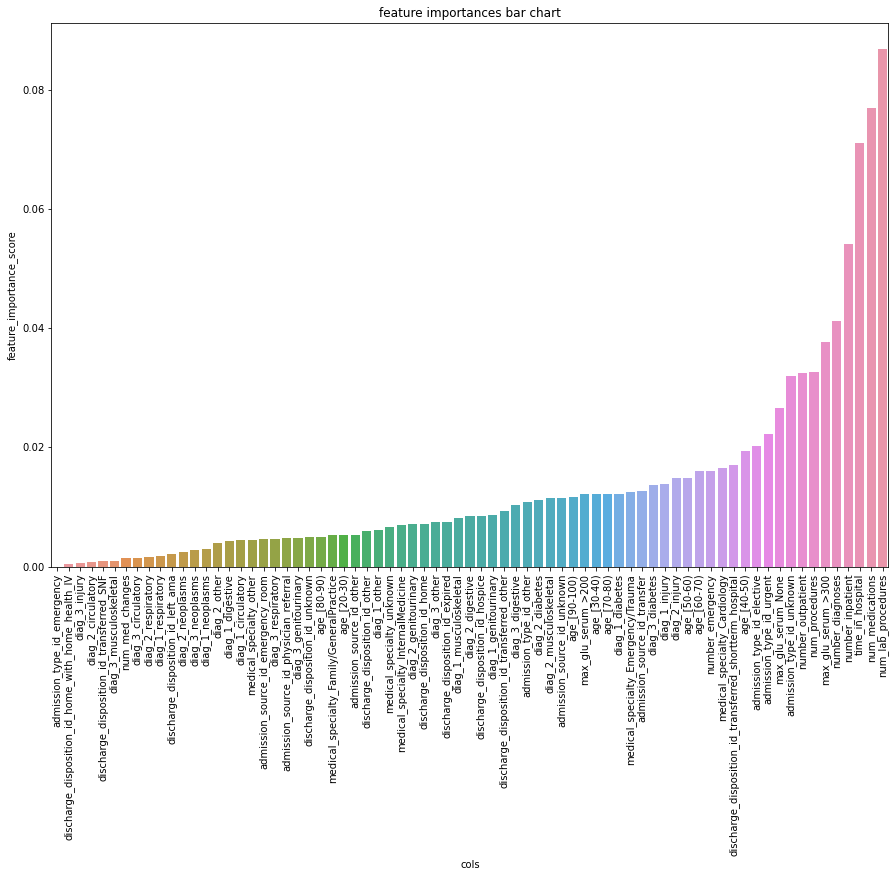

In [779]:
# plot the sorted features from above
# x-axis = feature names
# y-axis = feature importances scores

plt.figure(figsize=(15,10))
x = sns.barplot(x='cols', y='feature_importance_score', data=feat_imp_df)
x.set_xticklabels(x.get_xticklabels(), rotation=90)
plt.title('feature importances bar chart')
plt.show()

The feature importances values look small but that's because they're normalized. The RandomForestClassifier notes that the most important features are `num_lab_procedures`, `num_medications`, `time_in_hospital`, `number_inpatient`, `number_diagnoses`. Now let's append the predictions onto the train dataset.

In [184]:
# load data

df_classify_post_sampling = pd.read_csv('data/df_classify_post_sampling.csv', index_col='Unnamed: 0')

df_classify_post_sampling

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted
0,4,45,0,11,0,0,0,9,0,0,...,0,1,0,0,1,1,0,3,0,0
1,2,39,0,14,0,0,0,9,0,0,...,0,1,0,0,1,0,1,1,1,0
2,1,33,6,9,0,0,0,9,0,0,...,0,1,0,0,1,0,1,3,0,0
3,3,44,0,13,0,0,0,8,0,0,...,0,1,0,1,0,0,1,2,2,0
4,1,43,0,3,0,0,0,4,0,0,...,0,1,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48987,6,55,1,18,0,0,0,8,0,0,...,0,1,0,1,0,0,1,0,0,1
48988,12,64,5,22,15,0,0,9,0,0,...,0,1,0,0,0,0,1,1,1,1
48989,6,64,0,4,2,0,0,8,0,0,...,0,1,0,0,1,0,0,2,0,1
48990,2,64,0,14,0,0,0,4,1,0,...,0,1,0,1,0,0,1,2,1,1


In [780]:
# call predict to get the readmitted predictions

y_pred_train = rffittedgrid3.predict(X_train_classify)

y_pred_train

array([0, 0, 0, ..., 1, 1, 1])

In [185]:
# copy dataframe

df_classify_final_train = df_classify_post_sampling.copy()

# append predictions onto the train dataset

df_classify_final_train['readmitted_pred'] = y_pred_train

df_classify_final_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted,readmitted_pred
0,4,45,0,11,0,0,0,9,0,0,...,1,0,0,1,1,0,3,0,0,0
1,2,39,0,14,0,0,0,9,0,0,...,1,0,0,1,0,1,1,1,0,1
2,1,33,6,9,0,0,0,9,0,0,...,1,0,0,1,0,1,3,0,0,0
3,3,44,0,13,0,0,0,8,0,0,...,1,0,1,0,0,1,2,2,0,1
4,1,43,0,3,0,0,0,4,0,0,...,1,0,0,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48987,6,55,1,18,0,0,0,8,0,0,...,1,0,1,0,0,1,0,0,1,1
48988,12,64,5,22,15,0,0,9,0,0,...,1,0,0,0,0,1,1,1,1,1
48989,6,64,0,4,2,0,0,8,0,0,...,1,0,0,1,0,0,2,0,1,1
48990,2,64,0,14,0,0,0,4,1,0,...,1,0,1,0,0,1,2,1,1,1


Now that we've trained and found the best classifier via grid search, we're going to do the same feature engineering that we did on the train set on the test set.

In [500]:
# load data

df_classify_test = pd.read_csv('data/df_classify_testset.csv', index_col=[0])

df_classify_test.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,num_med_changes,race_orig,readmitted_orig,readmitted
62464,173973738,102910347,Caucasian,Male,[50-60),urgent,home,emergency_room,2,Emergency/Trauma,...,circulatory,9,None,None,Ch,Yes,1,Caucasian,>30,1
51065,152700834,58235868,Non_Caucasian,Female,[20-30),elective,home,physician_referral,2,other,...,other,7,None,None,No,No,0,AfricanAmerican,NO,0
29261,95724780,12614958,Non_Caucasian,Female,[70-80),urgent,home,transfer,11,other,...,musculoskeletal,5,None,None,No,Yes,0,AfricanAmerican,NO,0
76702,231841914,44028369,Caucasian,Male,[70-80),elective,home,physician_referral,1,other,...,circulatory,6,None,None,No,Yes,0,Caucasian,<30,1
76197,229651416,41854563,Caucasian,Female,[40-50),emergency,home,emergency_room,2,unknown,...,genitourinary,8,None,None,Ch,Yes,2,Caucasian,NO,0


### One-Hot Encoding on the Test Set

In [501]:
# assign X and y variables

X_test = df_classify_test.drop(['readmitted'], axis=1)
y_test = df_classify_test['readmitted']

In [502]:
# show columns

X_test.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'num_med_changes', 'race_orig', 'readmitted_orig'],
      dtype='object')

In [503]:
# instantiate the OneHotEncoder

ohe = OneHotEncoder()

# fit the OneHotEncoder 

categorical = X_test[['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id', \
                'medical_specialty','diag_1','diag_2','diag_3','max_glu_serum','A1Cresult','change','diabetesMed']]

# transform the features 

encoded = ohe.fit_transform(categorical) 
encoded

<20997x77 sparse matrix of type '<class 'numpy.float64'>'
	with 293958 stored elements in Compressed Sparse Row format>

In [504]:
# get categories of features

ohe.categories_

[array(['Caucasian', 'Non_Caucasian'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)',
        '[80-90)', '[90-100)'], dtype=object),
 array(['elective', 'emergency', 'other', 'unknown', 'urgent'],
       dtype=object),
 array(['expired', 'home', 'home_with_home_health_IV', 'hospice',
        'left_ama', 'other', 'transferred_SNF', 'transferred_other',
        'transferred_shortterm_hospital', 'unknown'], dtype=object),
 array(['emergency_room', 'other', 'physician_referral', 'transfer',
        'unknown'], dtype=object),
 array(['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
        'InternalMedicine', 'other', 'unknown'], dtype=object),
 array(['circulatory', 'diabetes', 'digestive', 'genitourinary', 'injury',
        'musculoskeletal', 'neoplasms', 'other', 'respiratory'],
       dtype=object),
 array(['circulatory', 'diabetes', 'digestive', 'genitourinary', 'injury',
        'musculoskel

In [505]:
# put into a dataframe to get column names

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded, index=X_test.index)
encoded_df.columns = ohe.get_feature_names(categorical.columns)

# show

encoded_df.head()

,race_Caucasian,race_Non_Caucasian,gender_Female,gender_Male,age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
62464,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
51065,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
29261,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
76702,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
76197,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [506]:
# check

X_test.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,num_med_changes,race_orig,readmitted_orig
62464,173973738,102910347,Caucasian,Male,[50-60),urgent,home,emergency_room,2,Emergency/Trauma,...,circulatory,circulatory,9,None,None,Ch,Yes,1,Caucasian,>30
51065,152700834,58235868,Non_Caucasian,Female,[20-30),elective,home,physician_referral,2,other,...,other,other,7,None,None,No,No,0,AfricanAmerican,NO
29261,95724780,12614958,Non_Caucasian,Female,[70-80),urgent,home,transfer,11,other,...,musculoskeletal,musculoskeletal,5,None,None,No,Yes,0,AfricanAmerican,NO
76702,231841914,44028369,Caucasian,Male,[70-80),elective,home,physician_referral,1,other,...,genitourinary,circulatory,6,None,None,No,Yes,0,Caucasian,<30
76197,229651416,41854563,Caucasian,Female,[40-50),emergency,home,emergency_room,2,unknown,...,genitourinary,genitourinary,8,None,None,Ch,Yes,2,Caucasian,NO


In [507]:
# convert float into int

encoded_df = encoded_df.astype('int64')

In [508]:
# check

encoded_df.head()

,race_Caucasian,race_Non_Caucasian,gender_Female,gender_Male,age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
62464,1,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,1
51065,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0
29261,0,1,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
76702,1,0,0,1,0,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
76197,1,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,1


After spot checking that the one-hot-encoding is done correctly, let's now join this new encoded_df back to the data set, drop the original features we've encoded.

In [510]:
# join encoded_df with X_test

df_model_pt = pd.merge(X_test, encoded_df, how='left', left_index=True, right_index=True)

In [511]:
# check

df_model_pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20997 entries, 62464 to 92144
Columns: 104 entries, encounter_id to diabetesMed_Yes
dtypes: Sparse[int64, 0](77), int64(11), object(16)
memory usage: 8.5+ MB


In [512]:
# show

df_model_pt.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
62464,173973738,102910347,Caucasian,Male,[50-60),urgent,home,emergency_room,2,Emergency/Trauma,...,1,0,0,0,1,0,1,0,0,1
51065,152700834,58235868,Non_Caucasian,Female,[20-30),elective,home,physician_referral,2,other,...,1,0,0,0,1,0,0,1,1,0
29261,95724780,12614958,Non_Caucasian,Female,[70-80),urgent,home,transfer,11,other,...,1,0,0,0,1,0,0,1,0,1
76702,231841914,44028369,Caucasian,Male,[70-80),elective,home,physician_referral,1,other,...,1,0,0,0,1,0,0,1,0,1
76197,229651416,41854563,Caucasian,Female,[40-50),emergency,home,emergency_room,2,unknown,...,1,0,0,0,1,0,1,0,0,1


In [106]:
# check

df_model_pt.loc[62464]['medical_specialty_unknown']

0

In [516]:
# save this df_model_pt to another df before dropping some categorical features

df_model_pt_predrop = df_model_pt.copy()

In [517]:
# drop columns

df_model_classify_t = df_model_pt.drop(columns=['encounter_id', 'patient_nbr', 'race', 'gender', 'age', \
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', \
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'change', \
       'diabetesMed', 'race_orig', 'readmitted_orig', 'race_Caucasian', 'race_Non_Caucasian', \
       'gender_Female', 'gender_Male'])

In [518]:
# show columns

df_model_classify_t.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'num_med_changes',
       'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)',
       'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)',
       'admission_type_id_elective', 'admission_type_id_emergency',
       'admission_type_id_other', 'admission_type_id_unknown',
       'admission_type_id_urgent', 'discharge_disposition_id_expired',
       'discharge_disposition_id_home',
       'discharge_disposition_id_home_with_home_health_IV',
       'discharge_disposition_id_hospice', 'discharge_disposition_id_left_ama',
       'discharge_disposition_id_other',
       'discharge_disposition_id_transferred_SNF',
       'discharge_disposition_id_transferred_other',
       'discharge_disposition_id_transferred_shortterm_hospital',
       'discharge_disposition_id_unknown',
       'admission_source_id_e

We're done with preprocessing on the test set. The next step would be to evaluate the RandomForestClassifier model, with optimal hyperparamters we've iterated through, on the test set. Before we do though, let's append the cluster labels back in and save it to csv before model evaluation. We can get the cluster labels from the csv file we saved in our clustering stage.

In [519]:
df_final_labels = pd.read_csv('data/df_final_cluster_labels.csv', index_col=[0])

df_final_labels.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[40-50),...,diag_3_respiratory,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.083333,0.230769,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692,0.25,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846,0.00,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2
5,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3,0
6,0.230769,0.526718,0.166667,0.2500,0.000000,0.0,0.000000,0.307692,0.00,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,3


In [520]:
# add cluster labels

df_model_classify_t['kmeans'] = df_final_labels.iloc[:,-2]
df_model_classify_t['agglom'] = df_final_labels.iloc[:,-1]

In [521]:
# check

df_model_classify_t.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom
62464,2,36,0,15,0,1,0,9,1,0,...,0,0,1,0,1,0,0,1,2,1
51065,2,51,1,10,6,0,0,7,0,1,...,0,0,1,0,0,1,1,0,3,0
29261,11,13,0,12,0,0,0,5,0,0,...,0,0,1,0,0,1,0,1,3,0
76702,1,26,0,7,1,0,0,6,0,0,...,0,0,1,0,0,1,0,1,3,0
76197,2,52,2,16,1,0,1,8,2,0,...,0,0,1,0,1,0,0,1,2,2


In [522]:
# check against the above

df_final_labels.loc[51065]

time_in_hospital                                     0.076923
num_lab_procedures                                   0.381679
num_procedures                                       0.166667
num_medications                                      0.112500
number_outpatient                                    0.142857
number_emergency                                     0.000000
number_inpatient                                     0.000000
number_diagnoses                                     0.307692
num_med_changes                                      0.000000
age_[40-50)                                          0.000000
age_[50-60)                                          0.000000
age_[60-70)                                          0.000000
age_[70-80)                                          0.000000
age_[80-90)                                          0.000000
admission_type_id_elective                           1.000000
admission_type_id_emergency                          0.000000
admissio

In [523]:
# output to csv

df_model_classify_t.to_csv('data/df_model_classify_testset.csv')

In [524]:
# drop cluster labels in order to evaluate model on test set

df_model_classify_t.drop(['kmeans','agglom'], axis=1, inplace=True)

df_model_classify_t.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
62464,2,36,0,15,0,1,0,9,1,0,...,1,0,0,0,1,0,1,0,0,1
51065,2,51,1,10,6,0,0,7,0,1,...,1,0,0,0,1,0,0,1,1,0
29261,11,13,0,12,0,0,0,5,0,0,...,1,0,0,0,1,0,0,1,0,1
76702,1,26,0,7,1,0,0,6,0,0,...,1,0,0,0,1,0,0,1,0,1
76197,2,52,2,16,1,0,1,8,2,0,...,1,0,0,0,1,0,1,0,0,1


In [525]:
# print test accuracy score

print('test score: ', rffittedgrid3.score(df_model_classify_t, y_test))

/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/sklearn/utils/validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


test score:  0.5992760870600562


Test accuracy score is ~0.60, which is okay but not great. 

Now, we also recognize that feature importances can be misleading for numerical features that have many unique values<sup>1</sup>, or high cardinality features. According to scikit-learn page, feature importances have two limitations:

- biased towards high cardinality features
- computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity)

Remember the variable that is a top feature importance? `num_lab_procedures`. We note that variables such as `num_lab_procedures` is a numerical feature with many unique values. So, as an alternative to feature importances, we can apply permutation importances<sup>2</sup>, but we'll do so on the test set given the 2nd limitation mentioned above.

In [805]:
%%time 

from sklearn.inspection import permutation_importance

# permutation importance for feature evaluation
# n_repeats = number of times to permute a feature

result = permutation_importance(rffittedgrid3, df_model_classify_t, y_test, n_repeats=10,
                                random_state=1, n_jobs=-1)

# importances_mean = mean of feature importance over n_repeats
# sort the results from smallest to largest importance

sorted_idx = result.importances_mean.argsort() # array of indices of the features

/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/sklearn/utils/validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


CPU times: user 13.7 s, sys: 4.75 s, total: 18.5 s
Wall time: 4min 42s


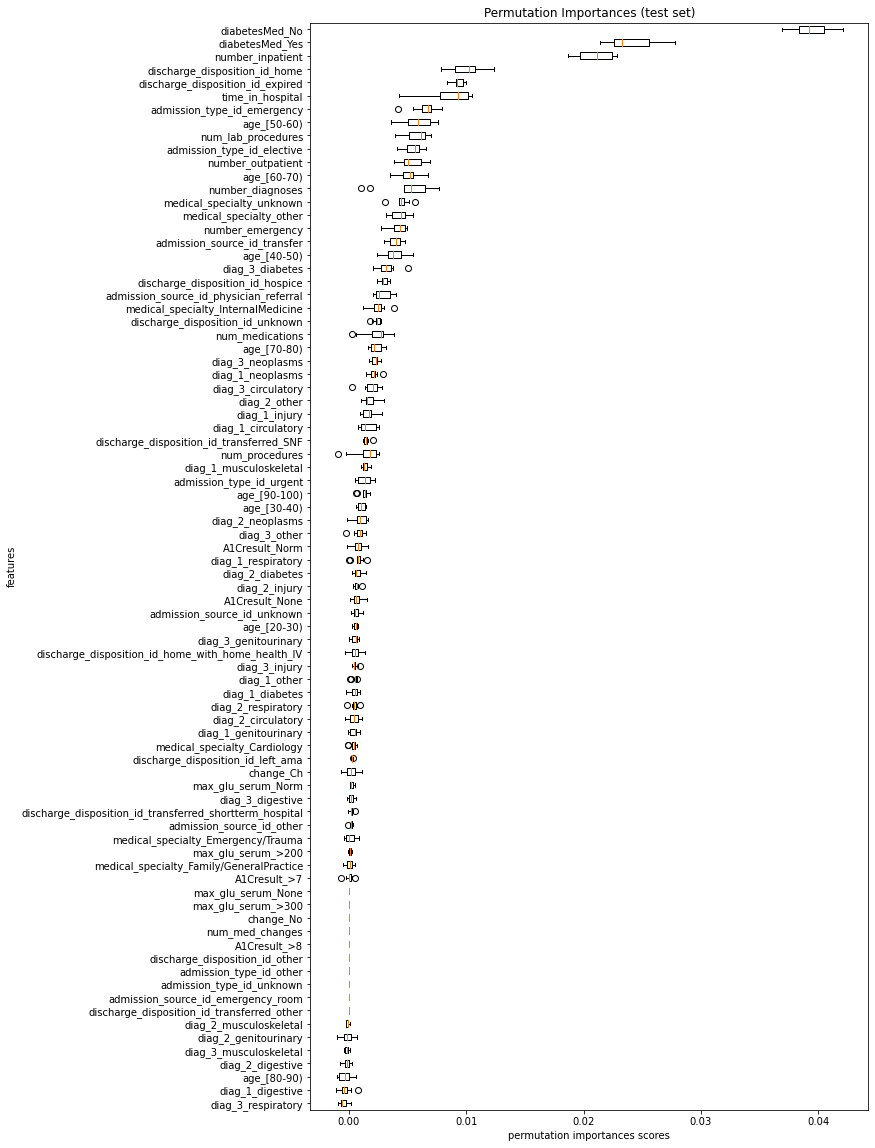

In [806]:
# boxplot the sorted results from above

fig, ax = plt.subplots(figsize=(10,20))

# vert=False means draw horizontal boxes
# order the features on the y-axis by the sorted values from above

ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=df_model_classify_t.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel('permutation importances scores')
ax.set_ylabel('features')
plt.show()

Since we have a lot of variables, let's just plot the same graph for the top 10 most important variables.

In [824]:
# importances_mean = mean of feature importance over n_repeats
# sort the results from smallest to largest importance

sorted_idx10 = result.importances_mean.argsort()[-10:] # -10 here is the last 10 indices in the array 
sorted_idx10                                           # that we know are associated with the top 10 most important

array([17,  1, 12, 18,  0, 22, 23,  6, 81, 80])

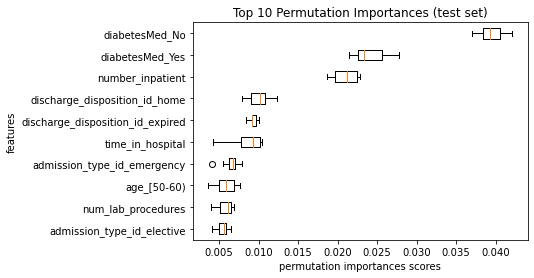

In [825]:
# boxplot the sorted results from above

fig, ax = plt.subplots()

# vert=False means draw horizontal boxes
# order the features on the y-axis by the sorted values from above

ax.boxplot(result.importances[sorted_idx10].T, vert=False, labels=df_model_classify_t.columns[sorted_idx10])
ax.set_title("Top 10 Permutation Importances (test set)")
ax.set_xlabel('permutation importances scores')
ax.set_ylabel('features')
plt.show()

As we can see from the boxplot above, the top 5 most important features are actually `diabetesMed_No`, `diabetesMed_Yes`, `number_inpatient`, `discharge_disposition_id_home` and `discharge_disposition_id_expired`. `num_lab_procedures` is ranked up there but it actually has low importances (close to 0). 

We would say `diabetesMed_No`, `diabetesMed_Yes` and `number_inpatient` are the important ones because they at least have importances >= 0.02. The rest are all <= 0.01.

Let's proceed with steps needed to append the model's predictions to the test set.

In [488]:
# get the test set's predictions

y_pred_test = rffittedgrid3.predict(df_model_classify_t)

y_pred_test

/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/sklearn/utils/validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


array([1, 0, 1, ..., 0, 0, 0])

In [530]:
# load data

df_classify_final_test = pd.read_csv('data/df_model_classify_testset.csv', index_col=[0])

df_classify_final_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom
62464,2,36,0,15,0,1,0,9,1,0,...,0,0,1,0,1,0,0,1,2,1
51065,2,51,1,10,6,0,0,7,0,1,...,0,0,1,0,0,1,1,0,3,0
29261,11,13,0,12,0,0,0,5,0,0,...,0,0,1,0,0,1,0,1,3,0
76702,1,26,0,7,1,0,0,6,0,0,...,0,0,1,0,0,1,0,1,3,0
76197,2,52,2,16,1,0,1,8,2,0,...,0,0,1,0,1,0,0,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,6,71,6,28,0,0,0,9,1,0,...,0,0,1,0,1,0,0,1,2,2
60712,7,71,6,25,0,1,1,9,0,0,...,0,0,1,0,1,0,0,1,2,2
56709,3,20,3,17,0,0,0,8,1,0,...,0,0,1,0,1,0,0,1,0,3
31580,4,51,4,16,0,0,0,9,0,0,...,0,0,1,0,0,1,1,0,3,0


In [531]:
# create a new column to append the test set's true readmitted values

df_classify_final_test['readmitted'] = y_test

df_classify_final_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted
62464,2,36,0,15,0,1,0,9,1,0,...,0,1,0,1,0,0,1,2,1,1
51065,2,51,1,10,6,0,0,7,0,1,...,0,1,0,0,1,1,0,3,0,0
29261,11,13,0,12,0,0,0,5,0,0,...,0,1,0,0,1,0,1,3,0,0
76702,1,26,0,7,1,0,0,6,0,0,...,0,1,0,0,1,0,1,3,0,1
76197,2,52,2,16,1,0,1,8,2,0,...,0,1,0,1,0,0,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,6,71,6,28,0,0,0,9,1,0,...,0,1,0,1,0,0,1,2,2,0
60712,7,71,6,25,0,1,1,9,0,0,...,0,1,0,1,0,0,1,2,2,1
56709,3,20,3,17,0,0,0,8,1,0,...,0,1,0,1,0,0,1,0,3,0
31580,4,51,4,16,0,0,0,9,0,0,...,0,1,0,0,1,1,0,3,0,0


In [532]:
# create a new column to append the test set's predicted readmitted values

df_classify_final_test['readmitted_pred'] = y_pred_test

df_classify_final_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted,readmitted_pred
62464,2,36,0,15,0,1,0,9,1,0,...,1,0,1,0,0,1,2,1,1,1
51065,2,51,1,10,6,0,0,7,0,1,...,1,0,0,1,1,0,3,0,0,0
29261,11,13,0,12,0,0,0,5,0,0,...,1,0,0,1,0,1,3,0,0,1
76702,1,26,0,7,1,0,0,6,0,0,...,1,0,0,1,0,1,3,0,1,0
76197,2,52,2,16,1,0,1,8,2,0,...,1,0,1,0,0,1,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,6,71,6,28,0,0,0,9,1,0,...,1,0,1,0,0,1,2,2,0,0
60712,7,71,6,25,0,1,1,9,0,0,...,1,0,1,0,0,1,2,2,1,1
56709,3,20,3,17,0,0,0,8,1,0,...,1,0,1,0,0,1,0,3,0,0
31580,4,51,4,16,0,0,0,9,0,0,...,1,0,0,1,1,0,3,0,0,0


Since we know that our test set has a class imbalance, we'll want to look at precision and recall metrics, besides accuracy. The reason being that accuracy alone is insufficient as a model evaluation metric when there's class imbalance - the model ends up learning mostly about the majority class but not enough about the minority class. A quick review of definitions:
- accuracy: of all the predictions the model makes, how many does the model make correctly?
- precision: of all the positive predictions the model makes, how many are truly positive?
- recall: of all the truly positive data points, how many does the model predict correctly as positive?

We can see these metrics' calculated values in a classification report.

In [534]:
# classification report

report_initial = classification_report(y_test, y_pred_test) # support tells you the # of data points
print(report_initial)

              precision    recall  f1-score   support

           0       0.67      0.64      0.66     12558
           1       0.50      0.54      0.52      8439

    accuracy                           0.60     20997
   macro avg       0.59      0.59      0.59     20997
weighted avg       0.60      0.60      0.60     20997



Our model's accuracy, when evaluated on the test data, is ~0.60. Note that for `readmitted` = 0, the precision value of ~0.68 is greater than the recall value of ~0.64. What this means is that the model is doing a better job at predicting those who are truly `readmitted` = 0 as 0, but it may be at the expense of missing some true 0's. For `readmitted` = 1, precision value of ~0.51 is less than the recall value of ~0.55. This means that the model is doing a better job at predicting true `readmitted` of 1 as 1's, but at the expense of predicting some true 0's as 1's.

This is good to know, but based on our methodology, we're more interested in these metrics on a cluster level, so let's calculate that for each cluster that we've found from our K-Means and Agglomerative clustering.

In [535]:
# create a dataframe for each cluster

k3a0_t = df_classify_final_test[(df_classify_final_test['kmeans']==3) & (df_classify_final_test['agglom']==0)]

k1a1_t = df_classify_final_test[(df_classify_final_test['kmeans']==1) & (df_classify_final_test['agglom']==1)]

k2a2_t = df_classify_final_test[(df_classify_final_test['kmeans']==2) & (df_classify_final_test['agglom']==2)]

k0a3_t = df_classify_final_test[(df_classify_final_test['kmeans']==0) & (df_classify_final_test['agglom']==3)]

In [312]:
# return the shape of each cluster

display(f'K3A0 test cluster shape: {k3a0_t.shape}')
display(f'K1A1 test cluster shape: {k1a1_t.shape}')
display(f'K2A2 test cluster shape: {k2a2_t.shape}')
display(f'K0A3 test cluster shape: {k0a3_t.shape}')

'K3A0 test cluster shape: (4664, 86)'

'K1A1 test cluster shape: (6249, 86)'

'K2A2 test cluster shape: (4408, 86)'

'K0A3 test cluster shape: (3065, 86)'

In [536]:
# classification report for k3a0 test cluster

report_k3a0_t = classification_report(k3a0_t['readmitted'], k3a0_t['readmitted_pred'])

print('k3a0 test cluster')
print(report_k3a0_t)

k3a0 test cluster
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2959
           1       0.50      0.46      0.48      1705

    accuracy                           0.63      4664
   macro avg       0.60      0.60      0.60      4664
weighted avg       0.63      0.63      0.63      4664



In [537]:
# classification report for k1a1 test cluster

report_k1a1_t = classification_report(k1a1_t['readmitted'], k1a1_t['readmitted_pred'])

print('k1a1 test cluster')
print(report_k1a1_t)

k1a1 test cluster
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      3786
           1       0.52      0.45      0.48      2463

    accuracy                           0.62      6249
   macro avg       0.59      0.59      0.59      6249
weighted avg       0.61      0.62      0.61      6249



In [538]:
# classification report for k2a2 test cluster

report_k2a2_t = classification_report(k2a2_t['readmitted'], k2a2_t['readmitted_pred'])

print('k2a2 test cluster')
print(report_k2a2_t)

k2a2 test cluster
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      2512
           1       0.50      0.59      0.54      1896

    accuracy                           0.57      4408
   macro avg       0.57      0.57      0.57      4408
weighted avg       0.58      0.57      0.57      4408



In [539]:
# classification report for k0a3 test cluster

report_k0a3_t = classification_report(k0a3_t['readmitted'], k0a3_t['readmitted_pred'])

print('k0a3 test cluster')
print(report_k0a3_t)

k0a3 test cluster
              precision    recall  f1-score   support

           0       0.69      0.55      0.61      1892
           1       0.45      0.60      0.51      1173

    accuracy                           0.57      3065
   macro avg       0.57      0.57      0.56      3065
weighted avg       0.60      0.57      0.57      3065



As we review the classification reports for each cluster, we'll just focus on recall as the evaluation metric since we know that the test set has class imbalance, and we care more about the algorithm "recalling" those who need hospital care, even if it's at the expense of having false positives. We note a few things:
- k3a0: of all the true values, the model is better at recalling the 0's than 1's; overall, the model has an easier time with predicting true 0's than 1's
- k1a1: of all the true values, the model is better at recalling the 0's than 1's; overall, the model has an easier time with predicting true 0's than 1's
- k2a2: of all the true values, the model does better at recalling the 1's than 0's
- k0a3: of all the true values, the model does better at recalling the 1's than 0's

Before we dig deeper to figure out why the classifier's recall against k3a0 and k1a1 are poorer, we ask the question, "what if the model's poorer performance is a function of unequal cluster sizes?"

There are more sophisticated methods to do this, but in our case, let's just randomly sample so that each cluster is the same size as k0a3 (the smallest cluster as we've checked above). We want to do downsampling because we want to keep the same indices for easier analysis later; upsampling wouldn't achieve that. We'll then combine all of the clusters in one dataframe, evaluate the same classifier on this new dataframe, and see whether or not the classifier continues to perform poorly against the same clusters.

In [540]:
# randomly sample each cluster so that they become the same size as k0a3 

k3a0_ts = k3a0_t.sample(n=3065, random_state=1)
k1a1_ts = k1a1_t.sample(n=3065, random_state=1)
k2a2_ts = k2a2_t.sample(n=3065, random_state=1)

In [801]:
# check 

display(k3a0_ts['readmitted'].value_counts(normalize=True))
display(k1a1_ts['readmitted'].value_counts(normalize=True))
display(k2a2_ts['readmitted'].value_counts(normalize=True))

0    0.642414
1    0.357586
Name: readmitted, dtype: float64

0    0.613703
1    0.386297
Name: readmitted, dtype: float64

0    0.567047
1    0.432953
Name: readmitted, dtype: float64

With downsampling, the proportions between class 1 and 0 remain as expected. 

Let's combine these test clusters into one dataframe so that we can evaluate the model on this dataset.

In [542]:
# combine all the test clusters together 

df_classify_test_sampled = pd.concat([k3a0_ts, k1a1_ts, k2a2_ts, k0a3_t])

In [543]:
# check

df_classify_test_sampled.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted,readmitted_pred
77606,4,48,2,15,0,0,0,9,0,0,...,1,0,0,1,1,0,3,0,0,0
70939,3,28,3,21,13,0,1,9,0,0,...,1,0,0,1,0,1,3,0,0,1
12405,2,32,2,13,0,0,0,8,0,0,...,1,0,0,1,1,0,3,0,1,0
24468,4,30,1,4,0,0,2,7,0,0,...,1,0,0,1,1,0,3,0,0,1
89215,3,15,2,23,0,0,0,4,0,0,...,1,0,0,1,1,0,3,0,1,0


In [544]:
# output to csv

df_classify_test_sampled.to_csv('data/df_classify_test_sampled.csv')

In [545]:
# drop cluster labels in order to evaluate model on test set

df_classify_test_sampled.drop(['kmeans','agglom','readmitted_pred'], axis=1, inplace=True)

df_classify_test_sampled.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted
77606,4,48,2,15,0,0,0,9,0,0,...,0,0,0,1,0,0,1,1,0,0
70939,3,28,3,21,13,0,1,9,0,0,...,0,0,0,1,0,0,1,0,1,0
12405,2,32,2,13,0,0,0,8,0,0,...,0,0,0,1,0,0,1,1,0,1
24468,4,30,1,4,0,0,2,7,0,0,...,0,0,0,1,0,0,1,1,0,0
89215,3,15,2,23,0,0,0,4,0,0,...,0,0,0,1,0,0,1,1,0,1


In [546]:
# split into the X and y variables

X_ts = df_classify_test_sampled.drop('readmitted', axis=1)
y_ts = df_classify_test_sampled['readmitted']

In [548]:
# print test accuracy score

print('test downsampled score: ', rffittedgrid3.score(X_ts, y_ts))

test downsampled score:  0.6010603588907014


The model accuracy has improved by a negligible amount, from ~0.599 to ~.601.

In [549]:
# get the predictions on the test downsampled set

y_pred_test_ts = rffittedgrid2.predict(X_ts)

y_pred_test_ts

array([0, 1, 0, ..., 1, 0, 0])

In [556]:
# copy the dataframe

df_classify_test_sampled2 = X_ts.copy()

In [557]:
# create a new column to append the test downsampled set's true readmitted values

df_classify_test_sampled2['readmitted'] = y_ts

df_classify_test_sampled2

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted
77606,4,48,2,15,0,0,0,9,0,0,...,0,0,0,1,0,0,1,1,0,0
70939,3,28,3,21,13,0,1,9,0,0,...,0,0,0,1,0,0,1,0,1,0
12405,2,32,2,13,0,0,0,8,0,0,...,0,0,0,1,0,0,1,1,0,1
24468,4,30,1,4,0,0,2,7,0,0,...,0,0,0,1,0,0,1,1,0,0
89215,3,15,2,23,0,0,0,4,0,0,...,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79983,4,34,1,27,0,0,0,8,0,0,...,0,0,0,1,0,1,0,0,1,0
99757,3,32,1,33,2,1,0,9,0,0,...,0,0,0,1,0,1,0,0,1,0
96915,6,51,0,14,0,0,1,9,0,0,...,0,0,0,1,0,1,0,0,1,0
28507,5,60,5,20,0,0,0,9,1,0,...,0,0,0,1,0,1,0,0,1,0


In [558]:
# create a new column to append the test downsampled set's predicted readmitted values

df_classify_test_sampled2['readmitted_pred'] = y_pred_test_ts

df_classify_test_sampled2

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted,readmitted_pred
77606,4,48,2,15,0,0,0,9,0,0,...,0,0,1,0,0,1,1,0,0,0
70939,3,28,3,21,13,0,1,9,0,0,...,0,0,1,0,0,1,0,1,0,1
12405,2,32,2,13,0,0,0,8,0,0,...,0,0,1,0,0,1,1,0,1,0
24468,4,30,1,4,0,0,2,7,0,0,...,0,0,1,0,0,1,1,0,0,1
89215,3,15,2,23,0,0,0,4,0,0,...,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79983,4,34,1,27,0,0,0,8,0,0,...,0,0,1,0,1,0,0,1,0,0
99757,3,32,1,33,2,1,0,9,0,0,...,0,0,1,0,1,0,0,1,0,1
96915,6,51,0,14,0,0,1,9,0,0,...,0,0,1,0,1,0,0,1,0,1
28507,5,60,5,20,0,0,0,9,1,0,...,0,0,1,0,1,0,0,1,0,0


In [554]:
# classification report

report_initial2 = classification_report(y_ts, y_pred_test_ts) 
print(report_initial2)

              precision    recall  f1-score   support

           0       0.69      0.65      0.67      7480
           1       0.50      0.54      0.52      4780

    accuracy                           0.61     12260
   macro avg       0.59      0.60      0.59     12260
weighted avg       0.61      0.61      0.61     12260



Recall score is the same at ~0.54 for class 1. We want to do the same in analyzing the metrics on a cluster level. We'll need to read in a csv we've saved prior and append the cluster labels before we can do the same steps in analyzing the metrics on a cluster level.

In [559]:
# load data

test2 = pd.read_csv('data/df_classify_test_sampled.csv', index_col=[0])

test2

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[20-30),...,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom,readmitted,readmitted_pred
77606,4,48,2,15,0,0,0,9,0,0,...,1,0,0,1,1,0,3,0,0,0
70939,3,28,3,21,13,0,1,9,0,0,...,1,0,0,1,0,1,3,0,0,1
12405,2,32,2,13,0,0,0,8,0,0,...,1,0,0,1,1,0,3,0,1,0
24468,4,30,1,4,0,0,2,7,0,0,...,1,0,0,1,1,0,3,0,0,1
89215,3,15,2,23,0,0,0,4,0,0,...,1,0,0,1,1,0,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79983,4,34,1,27,0,0,0,8,0,0,...,1,0,1,0,0,1,0,3,0,0
99757,3,32,1,33,2,1,0,9,0,0,...,1,0,1,0,0,1,0,3,0,1
96915,6,51,0,14,0,0,1,9,0,0,...,1,0,1,0,0,1,0,3,0,0
28507,5,60,5,20,0,0,0,9,1,0,...,1,0,1,0,0,1,0,3,0,0


In [560]:
# add cluster labels to the test downsampled dataframe

df_classify_test_sampled2['kmeans'] = test2.iloc[:,-4]

df_classify_test_sampled2['agglom'] = test2.iloc[:,-3]

And actually, we want variables like `race` and `gender` (from *df_model_pt* we assigned earlier) added back in as well. Let's do that.

In [802]:
# check

df_model_pt.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
62464,173973738,102910347,Caucasian,Male,[50-60),urgent,home,emergency_room,2,Emergency/Trauma,...,1,0,0,0,1,0,1,0,0,1
51065,152700834,58235868,Non_Caucasian,Female,[20-30),elective,home,physician_referral,2,other,...,1,0,0,0,1,0,0,1,1,0
29261,95724780,12614958,Non_Caucasian,Female,[70-80),urgent,home,transfer,11,other,...,1,0,0,0,1,0,0,1,0,1
76702,231841914,44028369,Caucasian,Male,[70-80),elective,home,physician_referral,1,other,...,1,0,0,0,1,0,0,1,0,1
76197,229651416,41854563,Caucasian,Female,[40-50),emergency,home,emergency_room,2,unknown,...,1,0,0,0,1,0,1,0,0,1


In [561]:
# add race and gender to the test downsampled dataframe

df_classify_test_sampled2['race'] = df_model_pt['race']

df_classify_test_sampled2['gender'] = df_model_pt['gender']

In [804]:
# spot check the above

df_classify_test_sampled2.loc[76197]

time_in_hospital              2
num_lab_procedures           52
num_procedures                2
num_medications              16
number_outpatient             1
                        ...    
readmitted_pred               1
kmeans                        2
agglom                        2
race                  Caucasian
gender                   Female
Name: 76197, Length: 88, dtype: object

In [567]:
# create individual dataframes again for each downsampled cluster

k0a3_sampled2 = df_classify_test_sampled2[(df_classify_test_sampled2['kmeans']==0) & \
                                         (df_classify_test_sampled2['agglom']==3)]

k1a1_sampled2 = df_classify_test_sampled2[(df_classify_test_sampled2['kmeans']==1) & \
                                         (df_classify_test_sampled2['agglom']==1)]

k2a2_sampled2 = df_classify_test_sampled2[(df_classify_test_sampled2['kmeans']==2) & \
                                         (df_classify_test_sampled2['agglom']==2)]

k3a0_sampled2 = df_classify_test_sampled2[(df_classify_test_sampled2['kmeans']==3) & \
                                         (df_classify_test_sampled2['agglom']==0)]

In [568]:
# classification report

report_k3a0_sampled2 = classification_report(k3a0_sampled2['readmitted'], k3a0_sampled2['readmitted_pred'])

print('k3a0 test sampled cluster')
print(report_k3a0_sampled2)

k3a0 test sampled cluster
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1969
           1       0.49      0.46      0.48      1096

    accuracy                           0.64      3065
   macro avg       0.60      0.60      0.60      3065
weighted avg       0.63      0.64      0.64      3065



In [569]:
# classification report

report_k1a1_sampled2 = classification_report(k1a1_sampled2['readmitted'], k1a1_sampled2['readmitted_pred'])

print('k1a1 test sampled cluster')
print(report_k1a1_sampled2)

k1a1 test sampled cluster
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1881
           1       0.53      0.46      0.49      1184

    accuracy                           0.63      3065
   macro avg       0.61      0.60      0.60      3065
weighted avg       0.63      0.63      0.63      3065



In [570]:
# classification report

report_k2a2_sampled2 = classification_report(k2a2_sampled2['readmitted'], k2a2_sampled2['readmitted_pred'])

print('k2a2 test sampled cluster')
print(report_k2a2_sampled2)

k2a2 test sampled cluster
              precision    recall  f1-score   support

           0       0.66      0.57      0.61      1738
           1       0.52      0.61      0.56      1327

    accuracy                           0.59      3065
   macro avg       0.59      0.59      0.59      3065
weighted avg       0.60      0.59      0.59      3065



In [571]:
# classification report

report_k0a3_sampled2 = classification_report(k0a3_sampled2['readmitted'], k0a3_sampled2['readmitted_pred'])

print('k0a3 test sampled cluster')
print(report_k0a3_sampled2)

k0a3 test sampled cluster
              precision    recall  f1-score   support

           0       0.69      0.54      0.61      1892
           1       0.45      0.61      0.52      1173

    accuracy                           0.57      3065
   macro avg       0.57      0.58      0.56      3065
weighted avg       0.60      0.57      0.57      3065



Even with the downsampling, precision and recall scores for each cluster have not drastically changed. 

What's the implication of this finding? It implies that the differences in recall - our metric of interest - are not a function of disparities in cluster sizes, but the differences are a function of what make up the clusters themselves. The model performs particular worse when it comes to recalling true 1's, specifically for k3a0 and k1a1 clusters. 

Remember what we've identified about these clusters in the clustering stage:

|   cluster  |  k3a0  |   k1a1  |  k2a2  |   k0a3  | 
| --------- |:---:|:---:|:---:|:---:|
|admission_source| physician referral | emergency | emergency | physician referral | 
|num_med_changes|0 |0 | 1+ | 1+ |
|diabetesMed| yes or no | yes or no | yes |yes |
|change| no | no | yes | yes |
|readmission=1 %| 36 | 39 | 43 | 39 |

And remember from permutation importance scores, the classifier deems `diabetesMed_No`, `diabetesMed_Yes` and `number_inpatient` as the most important features in contributing to the predictions.

As a result, it suggests that k3a0 and k1a1 having both 'yes' or 'no' for `diabetesMed` vs. k2a2 and k0a3 having only 'yes' for `diabetesMed` is an important differentiator. As an extension, it's also reasonable to say that k3a0 and k1a1 having no `change` in their diabetic medications vs. k2a2 and k0a3 having some `change` in their diabetic medications is also an important differentiator, and `num_med_changes` = 0 for k3a0 and k1a1 clusters vs. `num_med_changes` = 1+ as well. All in all, how the patients have been prescribed diabetic treatments looks to be a pattern that is a possible source of bias. The classifier's predictions would've had a disparate impact on these particular patients who belong in k3a0 or k1a1 clusters.

What about `number_inpatient`?

In [807]:
# return mean and mode for number_inpatient across the clusters

print('k3a0 mode:', k3a0_sampled2['number_inpatient'].mode())
print('\n')
print('k3a0 mean:', k3a0_sampled2['number_inpatient'].mean())
print('\n')
print('k1a1 mode:', k1a1_sampled2['number_inpatient'].mode())
print('\n')
print('k1a1 mean:', k1a1_sampled2['number_inpatient'].mean())
print('\n')
print('k2a2 mode:', k2a2_sampled2['number_inpatient'].mode())
print('\n')
print('k2a2 mean:', k2a2_sampled2['number_inpatient'].mean())
print('\n')
print('k0a3 mode:', k0a3_sampled2['number_inpatient'].mode())
print('\n')
print('k0a3 mean:', k0a3_sampled2['number_inpatient'].mean())

k3a0 mode: 0    0
dtype: int64


k3a0 mean: 0.17161500815660685


k1a1 mode: 0    0
dtype: int64


k1a1 mean: 0.1572593800978793


k2a2 mode: 0    0
dtype: int64


k2a2 mean: 0.20456769983686787


k0a3 mode: 0    0
dtype: int64


k0a3 mean: 0.16508972267536703


There aren't enough differences across these four clusters for us to call out anything distinct about `number_inpatient`. Below, even when we look at the strength of correlations between `number_inpatient` (plus other variables) with `readmitted`, they aren't high - mostly in the mid to high 0.10 range. We also may need to interpret these correlations with a grain of salt, since multicolinearity could factor in the interpretation of these correlations. In the RandomForestClassifier we've implemented l1 regularization to help address multicolinearity, but intuitively we know that these variables are still related with each other. We can see that, for example, `time_in_hospital` and `num_lab_procedures` are moderately correlated or that `number_diagnoses` and `time_in_hospital` has a positive correlation as well. 

*There are many correlation methods. We can't use Pearson's correlation because our variables don't meet the assumption of linear relationships between variables. The one we use below is Spearman's correlation, which is a nonparametric measure of the strength and direction of association that exists between two variables measured on at least an ordinal scale<sup>3</sup>. We can't see the correlations with `readmitted` for some variables such as `num_med_changes`, `change` or `diabetesMed`, because a cluster might only have one value for each variable.*

In [695]:
# return correlations for named columns, method = spearman

k3a0_sampled2.loc[:, k3a0_sampled2.columns.isin(['time_in_hospital', 'num_lab_procedures', 'num_procedures', \
                    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', \
                    'number_diagnoses', 'diabetesMed_No', 'diabetesMed_Yes', 'readmitted'])].corr(method='spearman')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diabetesMed_No,diabetesMed_Yes,readmitted
time_in_hospital,1.000000,0.306377,-0.032668,0.377786,-0.041884,0.011975,0.094043,0.220411,-0.025154,0.025154,0.077309
num_lab_procedures,0.306377,1.000000,0.026100,0.230085,-0.070149,0.003153,0.073085,0.163105,-0.025529,0.025529,0.052662
num_procedures,-0.032668,0.026100,1.000000,0.275983,-0.065268,-0.067741,-0.018956,0.008469,0.014478,-0.014478,-0.076343
num_medications,0.377786,0.230085,0.275983,1.000000,0.013951,0.022400,0.040732,0.197829,-0.107581,0.107581,0.007507
number_outpatient,-0.041884,-0.070149,-0.065268,0.013951,1.000000,0.128833,0.100566,0.070608,-0.047761,0.047761,0.079338
number_emergency,0.011975,0.003153,-0.067741,0.022400,0.128833,1.000000,0.163137,0.082049,-0.033450,0.033450,0.093708
number_inpatient,0.094043,0.073085,-0.018956,0.040732,0.100566,0.163137,1.000000,0.106034,-0.022587,0.022587,0.179162
number_diagnoses,0.220411,0.163105,0.008469,0.197829,0.070608,0.082049,0.106034,1.000000,-0.010715,0.010715,0.121096
diabetesMed_No,-0.025154,-0.025529,0.014478,-0.107581,-0.047761,-0.033450,-0.022587,-0.010715,1.000000,-1.000000,-0.056350
diabetesMed_Yes,0.025154,0.025529,-0.014478,0.107581,0.047761,0.033450,0.022587,0.010715,-1.000000,1.000000,0.056350


In [746]:
# return correlations for named columns, method = spearman

k1a1_sampled2.loc[:, k1a1_sampled2.columns.isin(['time_in_hospital', 'num_lab_procedures', 'num_procedures', \
                    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', \
                    'number_diagnoses', 'diabetesMed_No', 'diabetesMed_Yes', 'readmitted'])].corr(method='spearman')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diabetesMed_No,diabetesMed_Yes,readmitted
time_in_hospital,1.000000,0.318712,0.257107,0.490911,-0.026793,0.011784,0.074013,0.234941,-0.027140,0.027140,0.083144
num_lab_procedures,0.318712,1.000000,0.096565,0.327841,0.053034,0.066174,0.098908,0.122557,-0.014373,0.014373,0.037068
num_procedures,0.257107,0.096565,1.000000,0.327713,-0.025196,0.009632,0.001987,0.125246,0.022740,-0.022740,-0.026866
num_medications,0.490911,0.327841,0.327713,1.000000,0.043630,0.065667,0.106765,0.327833,-0.144536,0.144536,0.081292
number_outpatient,-0.026793,0.053034,-0.025196,0.043630,1.000000,0.152423,0.105929,0.116184,-0.024409,0.024409,0.106038
number_emergency,0.011784,0.066174,0.009632,0.065667,0.152423,1.000000,0.176878,0.100233,-0.041089,0.041089,0.136770
number_inpatient,0.074013,0.098908,0.001987,0.106765,0.105929,0.176878,1.000000,0.092695,-0.063254,0.063254,0.118718
number_diagnoses,0.234941,0.122557,0.125246,0.327833,0.116184,0.100233,0.092695,1.000000,-0.022235,0.022235,0.096471
diabetesMed_No,-0.027140,-0.014373,0.022740,-0.144536,-0.024409,-0.041089,-0.063254,-0.022235,1.000000,-1.000000,-0.066747
diabetesMed_Yes,0.027140,0.014373,-0.022740,0.144536,0.024409,0.041089,0.063254,0.022235,-1.000000,1.000000,0.066747


In [663]:
# return correlations for named columns, method = spearman

k2a2_sampled2.loc[:, k2a2_sampled2.columns.isin(['time_in_hospital', 'num_lab_procedures', 'num_procedures', \
                    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', \
                    'number_diagnoses', 'num_med_changes', 'readmitted'])].corr(method='spearman')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,readmitted
time_in_hospital,1.000000,0.357995,0.338631,0.533936,-0.003015,0.001586,0.042916,0.273457,0.171646,0.042841
num_lab_procedures,0.357995,1.000000,0.153429,0.317265,0.001928,0.020403,0.112281,0.176370,0.179485,0.059653
num_procedures,0.338631,0.153429,1.000000,0.428419,-0.030520,0.001008,-0.021025,0.136134,0.081569,-0.007897
num_medications,0.533936,0.317265,0.428419,1.000000,0.045065,0.005371,0.071235,0.368337,0.168034,0.081825
number_outpatient,-0.003015,0.001928,-0.030520,0.045065,1.000000,0.094623,0.070125,0.096340,-0.030508,0.069597
number_emergency,0.001586,0.020403,0.001008,0.005371,0.094623,1.000000,0.174219,0.054798,-0.000737,0.069747
number_inpatient,0.042916,0.112281,-0.021025,0.071235,0.070125,0.174219,1.000000,0.032163,0.039956,0.138979
number_diagnoses,0.273457,0.176370,0.136134,0.368337,0.096340,0.054798,0.032163,1.000000,0.053966,0.057021
num_med_changes,0.171646,0.179485,0.081569,0.168034,-0.030508,-0.000737,0.039956,0.053966,1.000000,0.029166
readmitted,0.042841,0.059653,-0.007897,0.081825,0.069597,0.069747,0.138979,0.057021,0.029166,1.000000


In [662]:
# return correlations for named columns, method = spearman

k0a3_sampled2.loc[:, k0a3_sampled2.columns.isin(['time_in_hospital', 'num_lab_procedures', 'num_procedures', \
                    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', \
                    'number_diagnoses', 'num_med_changes', 'readmitted'])].corr(method='spearman')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,readmitted
time_in_hospital,1.000000,0.442628,0.154795,0.433396,-0.004957,-0.027613,0.072226,0.245117,0.179514,0.033803
num_lab_procedures,0.442628,1.000000,0.057194,0.293656,0.013510,0.011673,0.044477,0.189448,0.177738,0.031104
num_procedures,0.154795,0.057194,1.000000,0.394086,-0.043385,-0.083168,-0.041838,0.041149,0.003090,-0.074981
num_medications,0.433396,0.293656,0.394086,1.000000,0.014566,-0.035485,-0.014279,0.209206,0.109861,-0.032744
number_outpatient,-0.004957,0.013510,-0.043385,0.014566,1.000000,0.141213,0.100525,0.068647,0.033662,0.082577
number_emergency,-0.027613,0.011673,-0.083168,-0.035485,0.141213,1.000000,0.093383,0.056286,0.019166,0.057337
number_inpatient,0.072226,0.044477,-0.041838,-0.014279,0.100525,0.093383,1.000000,0.064892,0.039920,0.112503
number_diagnoses,0.245117,0.189448,0.041149,0.209206,0.068647,0.056286,0.064892,1.000000,0.111340,0.112264
num_med_changes,0.179514,0.177738,0.003090,0.109861,0.033662,0.019166,0.039920,0.111340,1.000000,0.031267
readmitted,0.033803,0.031104,-0.074981,-0.032744,0.082577,0.057337,0.112503,0.112264,0.031267,1.000000


Just to check, are these correlations statistically significant? The null hypothesis says that the two variables are uncorrelated, but the alternative hypothesis says that there is correlation. We'll uphold a p-value of 0.05 here.

In [827]:
from scipy import stats

cols_to_loop = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', \
               'number_emergency', 'number_inpatient', 'number_diagnoses', 'num_med_changes']

for col in cols_to_loop:
    
    c,p = stats.spearmanr(k3a0_sampled2[col], k3a0_sampled2['readmitted'])
    
    print('---------------')
    print(col)
    print(c)
    print(p)

---------------
time_in_hospital
0.07730937293752939
1.829831862831666e-05
---------------
num_lab_procedures
0.052662228905545894
0.0035415975906584953
---------------
num_procedures
-0.07634275262578531
2.326829824411523e-05
---------------
num_medications
0.007506527979224912
0.6778373553241837
---------------
number_outpatient
0.07933753486412728
1.0952462979159423e-05
---------------
number_emergency
0.09370835887576624
2.0226189972555979e-07
---------------
number_inpatient
0.1791621516975029
1.5901652138921192e-23
---------------
number_diagnoses
0.12109585414191536
1.7415942080409875e-11
---------------
num_med_changes
nan
nan


/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/anaconda3/envs/imbalanced/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [828]:
cols_to_loop = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', \
               'number_emergency', 'number_inpatient', 'number_diagnoses', 'num_med_changes']

for col in cols_to_loop:
    
    c,p = stats.spearmanr(k1a1_sampled2[col], k1a1_sampled2['readmitted'])
    
    print('---------------')
    print(col)
    print(c)
    print(p)

---------------
time_in_hospital
0.08314364959703034
4.043383727480914e-06
---------------
num_lab_procedures
0.037067624208685056
0.04016749633401807
---------------
num_procedures
-0.026866405445278647
0.1370012085168781
---------------
num_medications
0.08129233177204163
6.600961022129515e-06
---------------
number_outpatient
0.10603833032569017
3.986717256500638e-09
---------------
number_emergency
0.13677049624800988
2.857414864326188e-14
---------------
number_inpatient
0.11871761081445055
4.306100500402493e-11
---------------
number_diagnoses
0.09647060925401635
8.739486852296264e-08
---------------
num_med_changes
nan
nan


In [829]:
cols_to_loop = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', \
               'number_emergency', 'number_inpatient', 'number_diagnoses', 'num_med_changes']

for col in cols_to_loop:
    
    c,p = stats.spearmanr(k2a2_sampled2[col], k2a2_sampled2['readmitted'])
    
    print('---------------')
    print(col)
    print(c)
    print(p)

---------------
time_in_hospital
0.04284094209230243
0.017696848963091656
---------------
num_lab_procedures
0.0596529798041162
0.0009527161823907259
---------------
num_procedures
-0.007896696396124205
0.6621049069840285
---------------
num_medications
0.08182503214426252
5.738743844731304e-06
---------------
number_outpatient
0.06959719037722728
0.00011517501251195998
---------------
number_emergency
0.06974742904510839
0.00011130802116216817
---------------
number_inpatient
0.13897855367031697
1.0874721632698345e-14
---------------
number_diagnoses
0.0570208632542445
0.0015880319463998944
---------------
num_med_changes
0.02916627433709358
0.10644048634810634


In [830]:
cols_to_loop = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', \
               'number_emergency', 'number_inpatient', 'number_diagnoses', 'num_med_changes']

for col in cols_to_loop:
    
    c,p = stats.spearmanr(k0a3_sampled2[col], k0a3_sampled2['readmitted'])
    
    print('---------------')
    print(col)
    print(c)
    print(p)

---------------
time_in_hospital
0.033802520446457
0.06132270981064979
---------------
num_lab_procedures
0.03110406186088841
0.08512189048722081
---------------
num_procedures
-0.07498068813226776
3.2490243362102445e-05
---------------
num_medications
-0.03274432347487137
0.06990090456702597
---------------
number_outpatient
0.08257700039039532
4.702981823586469e-06
---------------
number_emergency
0.05733746937008579
0.0014949598437907212
---------------
number_inpatient
0.11250320310600878
4.217753633091595e-10
---------------
number_diagnoses
0.1122641641933244
4.593622142255636e-10
---------------
num_med_changes
0.03126726547797455
0.08349650211200137


At least we can confirm that we can reject the null hypothesis for `number_inpatient` and `readmitted` across these four clusters since the p-values are all below 0.05. Note that there are some variables for which we cannot reject the null hypothesis, such as `num_medications` for k3a0 or `num_procedures` for k1a1. We'll move on for now but it's always good to check p-values as a practice.

As a last step, we're now interested in knowing if we can find the strength of relationship between `race` and `readmitted`. To help us do that, we're going to look at a statistic called the Phi coefficient. Phi coefficient calculates the correlation between two binary variables, and in our case `readmitted` is binary and we can turn `race` into binary as well. Note that we have Caucasians as 1 and non-Caucasians as 0.

In [650]:
# turn race into binary
# if Caucasian then 1 else 0

k3a0_sampled2_race = k3a0_sampled2['race'].apply(lambda x: 1 if (x == 'Caucasian') else 0)

k3a0_sampled2_race.value_counts()

1    2403
0     662
Name: race, dtype: int64

In [649]:
# return Phi coefficient

from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(k3a0_sampled2_race, k3a0_sampled2['readmitted'])

0.012773478916958746

In [651]:
# turn race into binary
# if Caucasian then 1 else 0

k1a1_sampled2_race = k1a1_sampled2['race'].apply(lambda x: 1 if (x == 'Caucasian') else 0)

k1a1_sampled2_race.value_counts()

1    2248
0     817
Name: race, dtype: int64

In [652]:
# return Phi coefficient

matthews_corrcoef(k1a1_sampled2_race, k1a1_sampled2['readmitted'])

0.058504563263838544

In [653]:
# turn race into binary
# if Caucasian then 1 else 0

k2a2_sampled2_race = k2a2_sampled2['race'].apply(lambda x: 1 if (x == 'Caucasian') else 0)

k2a2_sampled2_race.value_counts()

1    2128
0     937
Name: race, dtype: int64

In [654]:
# return Phi coefficient

matthews_corrcoef(k2a2_sampled2_race, k2a2_sampled2['readmitted'])

0.058137980074196766

In [655]:
# turn race into binary
# if Caucasian then 1 else 0

k0a3_sampled2_race = k0a3_sampled2['race'].apply(lambda x: 1 if (x == 'Caucasian') else 0)

k0a3_sampled2_race.value_counts()

1    2385
0     680
Name: race, dtype: int64

In [656]:
# return Phi coefficient

matthews_corrcoef(k0a3_sampled2_race, k0a3_sampled2['readmitted'])

0.056934544418867125

The Phi coefficients all return positive but very small, to the point of being negligible. This tells us that with our data, we cannot make a direct relationship between `race` and `readmitted`. However, as we'll mention below, there have been outside research that has found associations between demographics and healthcare access.

### Conclusion and Next Steps

In summary, based on the classifier's poor recall performance against particular clusters, and our exploratory knowledge of the clusters during the previous clustering analysis stage, there does suggest some algorithmic bias in hospital readmission specifically regarding diabetic treatments, dosage changes or generic name changes - or how the patients are prescribed diabetic medications at the time. Meaning, this algorithm wouldn't have done a great job at predicting properly those should be readmitted (and by should, we are basing it upon those who were readmitted based on the true labels). This would be a concern because it would have a disparate impact on those who belong in the k1a1 cluster with admission source as emergency. Outside research<sup>4</sup> has shown that those who have more emergency room visits are more likely to be African American, more likely to have limited health literacy, and more likely to have poor healthcare access and therefore less likely to have a regular physician. A person's lack of healthcare access also means that medical history on record might not be complete, which could affect the algorithm's predictions as well (remember that `number_inpatient` visits the year prior is a variable related to medical history and it's an important feature for the classifier). *Please note the dataset used and this referenced outside research are dated before the Affordable Care Act.*

Further research and statistical work are needed to build upon this work though, as we acknowledge that this current iteration of classifier modeling may need to be further refined to better tease out correlations and make more definitive conclusions. We would like to do the following as next steps:

- Recollect data so that we know the data is representative of the population
- Include more informative variables such as comorbidities, or do more iterations of feature engineering such as creating a new medication variable that emphasizes insulin
- Do more iterations in the clustering stage, especially with the hyperparameter tunings
- Do more iterations of RandomForestClassifier to reduce multicolinearity even further
- Explore the effectiveness of other classification methods, such as KNeighborsClassifier
- Do more rigorous statistical testing
- Collaborate with health domain experts starting with data recollection, since we started this research using complete case analysis but that might not have been the best approach
- Identify ways to reduce algorithmic bias

References:

<sup>1</sup> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<sup>2</sup> https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

<sup>3</sup> https://statistics.laerd.com/spss-tutorials/spearmans-rank-order-correlation-using-spss-statistics.php

<sup>4</sup> Sudore RL, Mehta KM, Simonsick EM, et al. Limited literacy in older people and disparities in health and healthcare access. J Am Geriatr Soc. 2006;54(5):770-776. doi:10.1111/j.1532-5415.2006.00691.x